# CAUSAL INFORMED PREDICTIVE MONITORING
---
## Dataset: BPI Challenge 2013

imports

In [25]:
import pandas as pd
import missingno as msno
import causality
import elp

load the data


In [26]:
log = pd.read_csv(
    "../data/BPI_Challenge_2013_incident.csv", sep=";", encoding="iso-8859-1"
)

In [27]:
log.head()

,SR Number,Change Date+Time,Status,Sub Status,Involved ST Function Div,Involved Org line 3,Involved ST,SR Latest Impact,Product,Country,Owner Country,Owner First Name
0,1-364285768,2010-03-31T15:59:42+01:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
1,1-364285768,2010-03-31T16:00:56+01:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
2,1-364285768,2010-03-31T16:45:48+01:00,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Frederic
3,1-364285768,2010-04-06T15:44:07+01:00,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Anne Claire
4,1-364285768,2010-04-06T15:44:38+01:00,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Anne Claire


In [28]:
log.describe()

,SR Number,Change Date+Time,Status,Sub Status,Involved ST Function Div,Involved Org line 3,Involved ST,SR Latest Impact,Product,Country,Owner Country,Owner First Name
count,65533,65533,65533,65533,58583,65533,65533,65533,65533,65533,65533,65533
unique,7554,60023,4,13,23,25,649,4,704,23,32,1440
top,1-687082195,2012-05-03T00:05:29+01:00,Accepted,In Progress,V3_2,Org line C,G97,Medium,PROD424,se,Sweden,Siebel
freq,123,9,40117,30239,30950,42189,7466,34905,8728,21060,18905,6162


<Axes: >

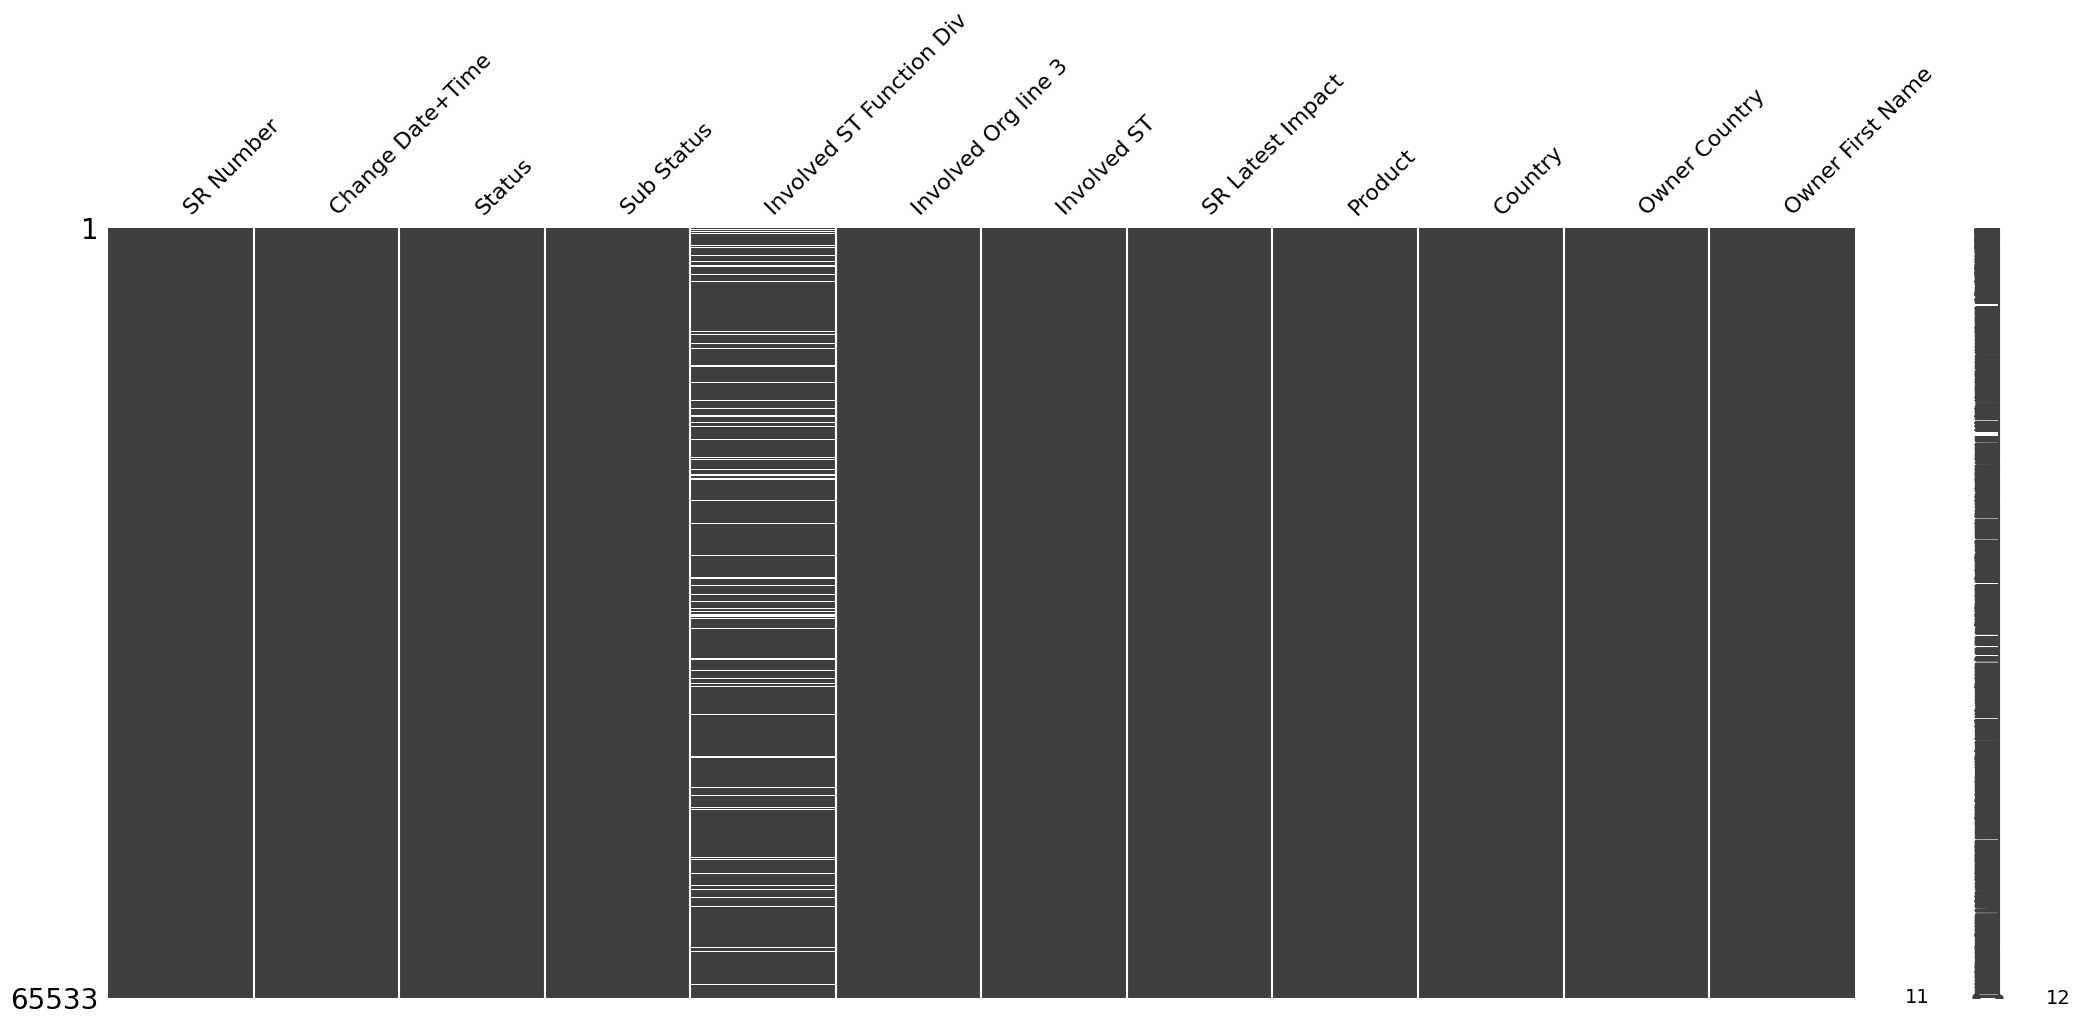

In [29]:
msno.matrix(log)

In [30]:
log["Involved ST Function Div"].fillna("UNKNOWN", inplace=True)

/var/folders/lr/h243hf4s6wl2jnyg3s9h3jlm0000gn/T/ipykernel_64687/349349205.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  log["Involved ST Function Div"].fillna("UNKNOWN", inplace=True)


<Axes: >

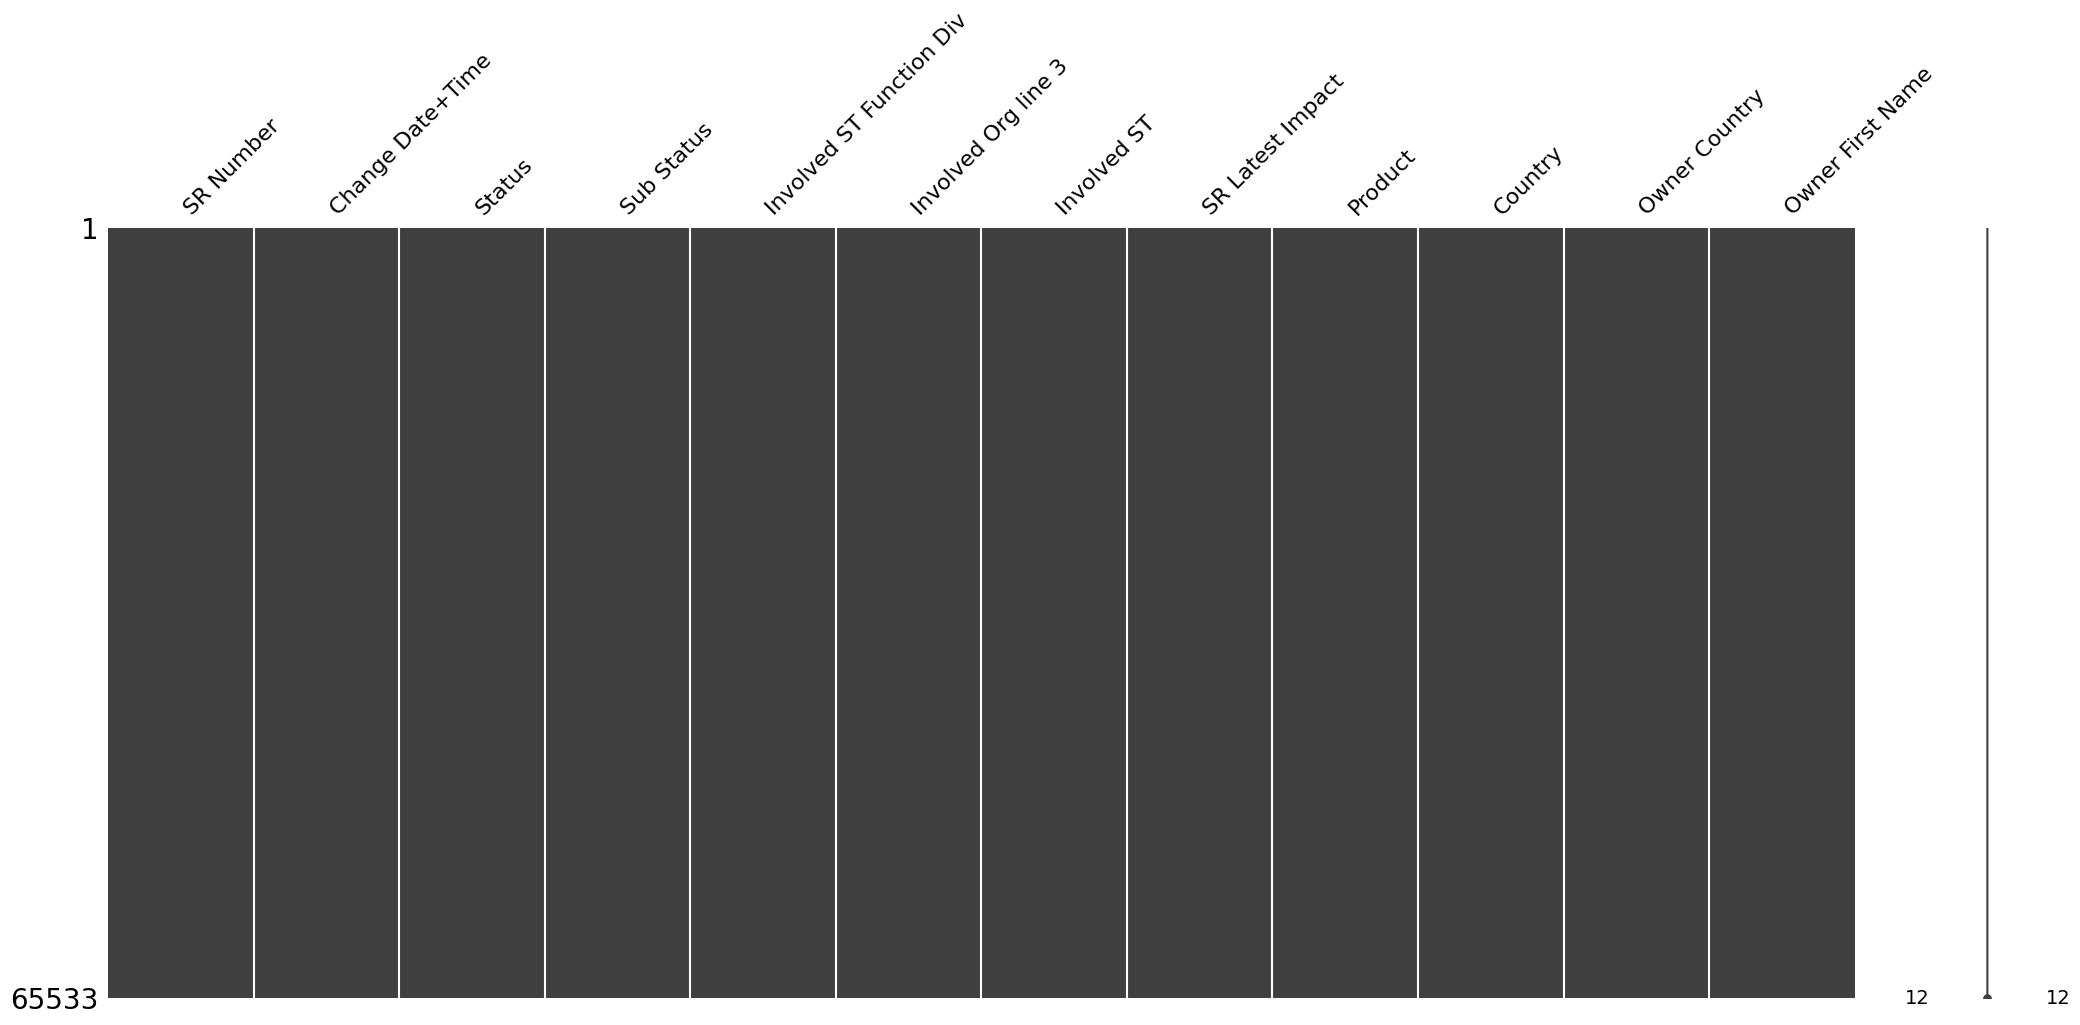

In [31]:
msno.matrix(log)

In [32]:
log.rename(columns={"SR Number": "id", "Change Date+Time": "timestamp"}, inplace=True)

In [33]:
log

,id,timestamp,Status,Sub Status,Involved ST Function Div,Involved Org line 3,Involved ST,SR Latest Impact,Product,Country,Owner Country,Owner First Name
0,1-364285768,2010-03-31T15:59:42+01:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
1,1-364285768,2010-03-31T16:00:56+01:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
2,1-364285768,2010-03-31T16:45:48+01:00,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Frederic
3,1-364285768,2010-04-06T15:44:07+01:00,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Anne Claire
4,1-364285768,2010-04-06T15:44:38+01:00,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Anne Claire
...,...,...,...,...,...,...,...,...,...,...,...,...
65528,1-740866691,2012-05-05T03:07:43+01:00,Completed,In Call,V3_2,Org line C,C9,Low,PROD424,br,Brazil,Lierson
65529,1-740866708,2012-05-05T05:58:40+01:00,Accepted,In Progress,V3_2,Org line C,C9,Medium,PROD562,br,Brazil,Lierson
65530,1-740866708,2012-05-05T06:02:39+01:00,Accepted,In Progress,V3_2,Org line C,C9,Medium,PROD562,br,Brazil,Lierson
65531,1-740866708,2012-05-05T06:23:03+01:00,Completed,In Call,V3_2,Org line C,C9,Medium,PROD562,br,Brazil,Lierson


In [34]:
log["id"].describe()

count           65533
unique           7554
top       1-687082195
freq              123
Name: id, dtype: object

In [35]:
log["timestamp"]

0        2010-03-31T15:59:42+01:00
1        2010-03-31T16:00:56+01:00
2        2010-03-31T16:45:48+01:00
3        2010-04-06T15:44:07+01:00
4        2010-04-06T15:44:38+01:00
                   ...            
65528    2012-05-05T03:07:43+01:00
65529    2012-05-05T05:58:40+01:00
65530    2012-05-05T06:02:39+01:00
65531    2012-05-05T06:23:03+01:00
65532    2012-05-05T13:54:27+01:00
Name: timestamp, Length: 65533, dtype: object

preprocessing and encode

In [36]:
log = elp.EventLog(log, "id", "timestamp")

/Users/adrf/Desktop/work/process.mining/code/causal.predictive.monitoring/.venv/lib/python3.12/site-packages/elp/event_log.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temp = pd.to_datetime(


In [37]:
log.df.columns

Index(['id', 'timestamp', 'Status', 'Sub Status', 'Involved ST Function Div',
       'Involved Org line 3', 'Involved ST', 'SR Latest Impact', 'Product',
       'Country', 'Owner Country', 'Owner First Name'],
      dtype='object')

In [38]:
log.df.head()

,id,timestamp,Status,Sub Status,Involved ST Function Div,Involved Org line 3,Involved ST,SR Latest Impact,Product,Country,Owner Country,Owner First Name
0,1-364285768,2010-03-31 14:59:42+00:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
1,1-364285768,2010-03-31 15:00:56+00:00,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Frederic
2,1-364285768,2010-03-31 15:45:48+00:00,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Frederic
3,1-364285768,2010-04-06 14:44:07+00:00,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,Anne Claire
4,1-364285768,2010-04-06 14:44:38+00:00,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France,Anne Claire


In [39]:
colums_to_encode = list(log.df.select_dtypes(include="object").columns)
colums_to_encode.remove("id")
print(colums_to_encode)

causality.label_encode(log.df, colums_to_encode)

log.df.head()

['Status', 'Sub Status', 'Involved ST Function Div', 'Involved Org line 3', 'Involved ST', 'SR Latest Impact', 'Product', 'Country', 'Owner Country', 'Owner First Name']


,id,timestamp,Status,Sub Status,Involved ST Function Div,Involved Org line 3,Involved ST,SR Latest Impact,Product,Country,Owner Country,Owner First Name
0,1-364285768,2010-03-31 14:59:42+00:00,0,5,3,0,578,3,455,9,11,389
1,1-364285768,2010-03-31 15:00:56+00:00,0,5,3,0,578,3,455,9,11,389
2,1-364285768,2010-03-31 15:45:48+00:00,2,1,4,0,608,3,455,9,11,389
3,1-364285768,2010-04-06 14:44:07+00:00,0,5,4,0,608,3,455,9,11,100
4,1-364285768,2010-04-06 14:44:38+00:00,2,1,3,0,578,3,455,9,11,100


In [40]:
import elp.encoders as en

encoder = en.LogEncoder(
    transformers=[
        ("drop", "drop", ["id"]),
        (
            "keep",
            "keep",
            [
                "Involved ST Function Div",
                "Involved Org line 3",
                "Involved ST",
                "Status",
                "Sub Status",
                "Owner Country",
                "Owner First Name",
                "SR Latest Impact",
                "Product",
                "Country",
            ],
        ),
        (
            "timestamp",
            en.TimestampFeatures(
                log.id_column,
                [
                    "event_order",
                    "time_from_start",
                    "time_from_midnight",
                    "total_time",
                    "elapsed_time_from_event",
                ],
                unit="1h",
            ),
            [log.timestamp_column],
        ),
    ]
)

encoder.check_unused(log)

[]

In [41]:
dataset = encoder.fit_transform(log)

Fitting drop
Fitting keep
Fitting timestamp
Transforming drop
Transforming keep
Transforming timestamp


In [42]:
dataset

,Involved ST Function Div,Involved Org line 3,Involved ST,Status,Sub Status,Owner Country,Owner First Name,SR Latest Impact,Product,Country,event_order_timestamp,time_from_start_timestamp,time_from_midnight_timestamp,total_time_timestamp,elapsed_time_from_event_timestamp
0,3,0,578,0,5,11,389,3,455,9,0,0.000000,14.995000,18512.442500,0.000000
1,3,0,578,0,5,11,389,3,455,9,1,0.020556,15.015556,18512.442500,0.020556
2,4,0,608,2,1,11,389,3,455,9,2,0.768333,15.763333,18512.442500,0.747778
3,4,0,608,0,5,11,100,3,455,9,3,143.740278,14.735278,18512.442500,142.971944
4,3,0,578,2,1,11,100,3,455,9,4,143.748889,14.743889,18512.442500,0.008611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65528,22,2,45,1,4,5,734,1,307,4,2,0.106111,2.128611,0.106111,0.095833
65529,22,2,45,0,5,5,734,3,437,4,0,0.000000,4.977778,0.406389,0.000000
65530,22,2,45,0,5,5,734,3,437,4,1,0.066389,5.044167,0.406389,0.066389
65531,22,2,45,1,4,5,734,3,437,4,2,0.406389,5.384167,0.406389,0.340000


run base experiment

Split 0: 10923 train rows, 10922 test rows
{'mse': 782.1843721966485, 'rmse': 27.967559282079808, 'split': 0}


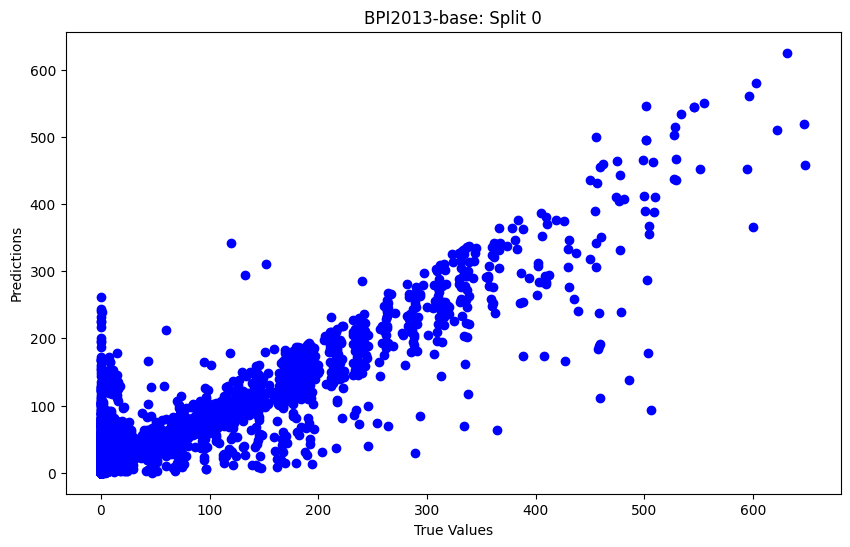

Split 1: 21845 train rows, 10922 test rows
{'mse': 384.1243608843829, 'rmse': 19.59909081780027, 'split': 1}


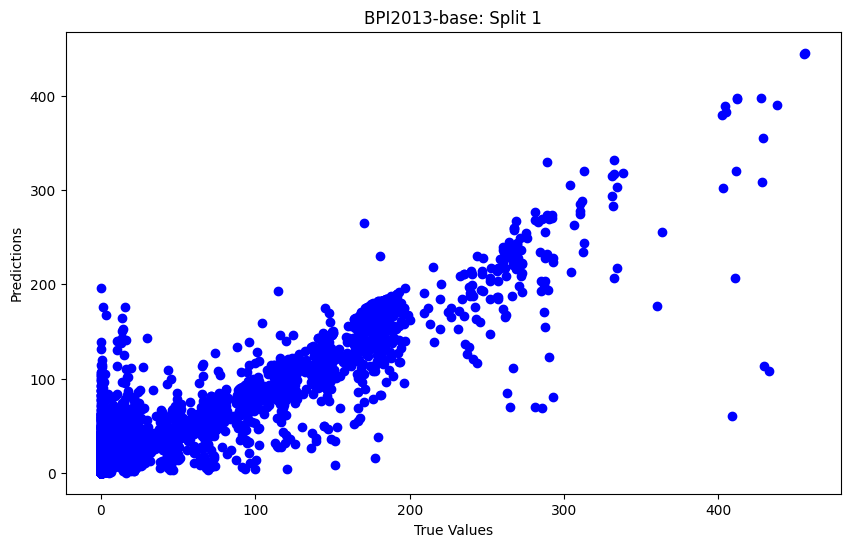

Split 2: 32767 train rows, 10922 test rows
{'mse': 64.30478490283558, 'rmse': 8.019026431109676, 'split': 2}


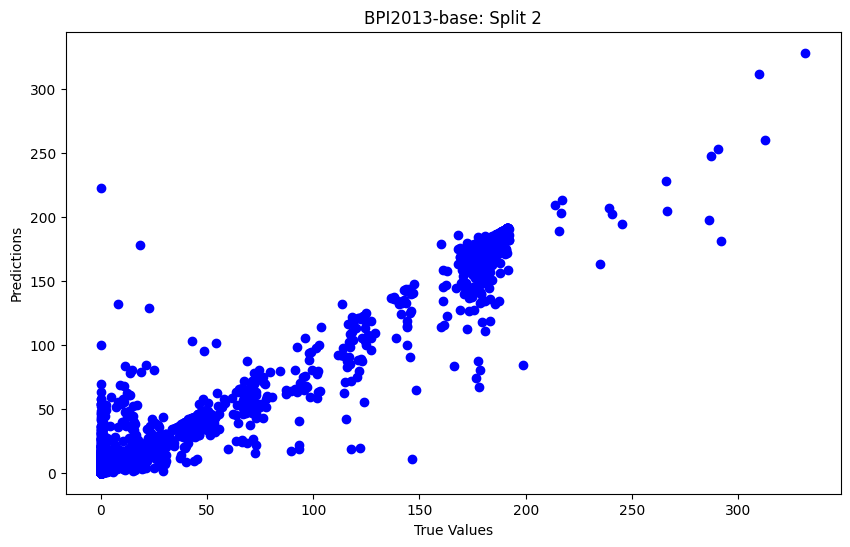

Split 3: 43689 train rows, 10922 test rows
{'mse': 78.17498398844502, 'rmse': 8.841661834092335, 'split': 3}


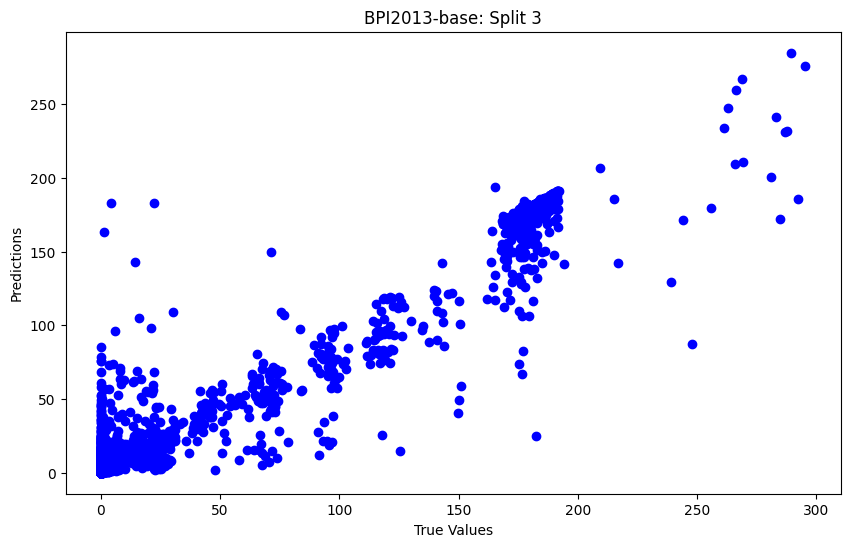

Split 4: 54611 train rows, 10922 test rows
{'mse': 57.96655640052355, 'rmse': 7.613577109383181, 'split': 4}


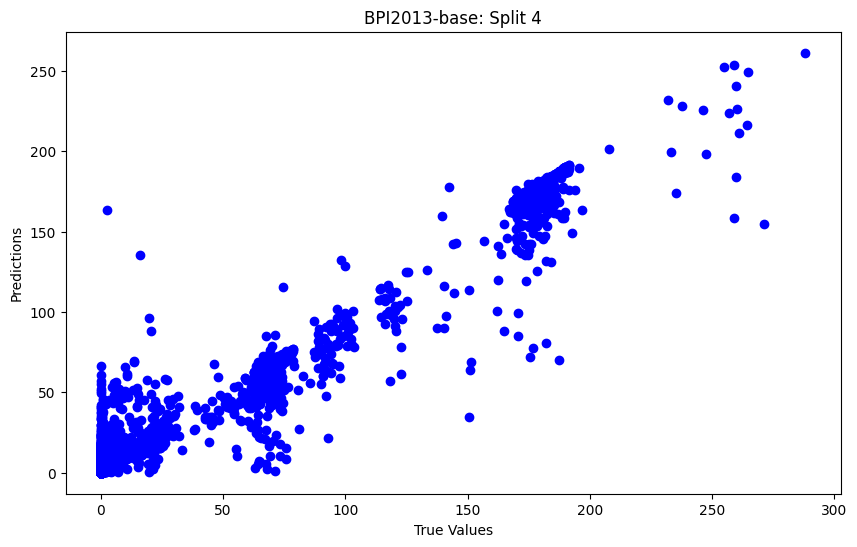

{'mse': 273.3510116745671, 'rmse': 14.408183094893056}


In [43]:
results_base = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2013",
    experiment="base",
)

causal inference and causal informed prediction

Depth=0, working on node 0:   0%|          | 0/15 [00:00<?, ?it/s]

Depth=0, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1159.48it/s]


X8 --> X1
X12 --> X2
X10 --> X3
X10 --> X6
X13 --> X7
X15 --> X7
X15 --> X13


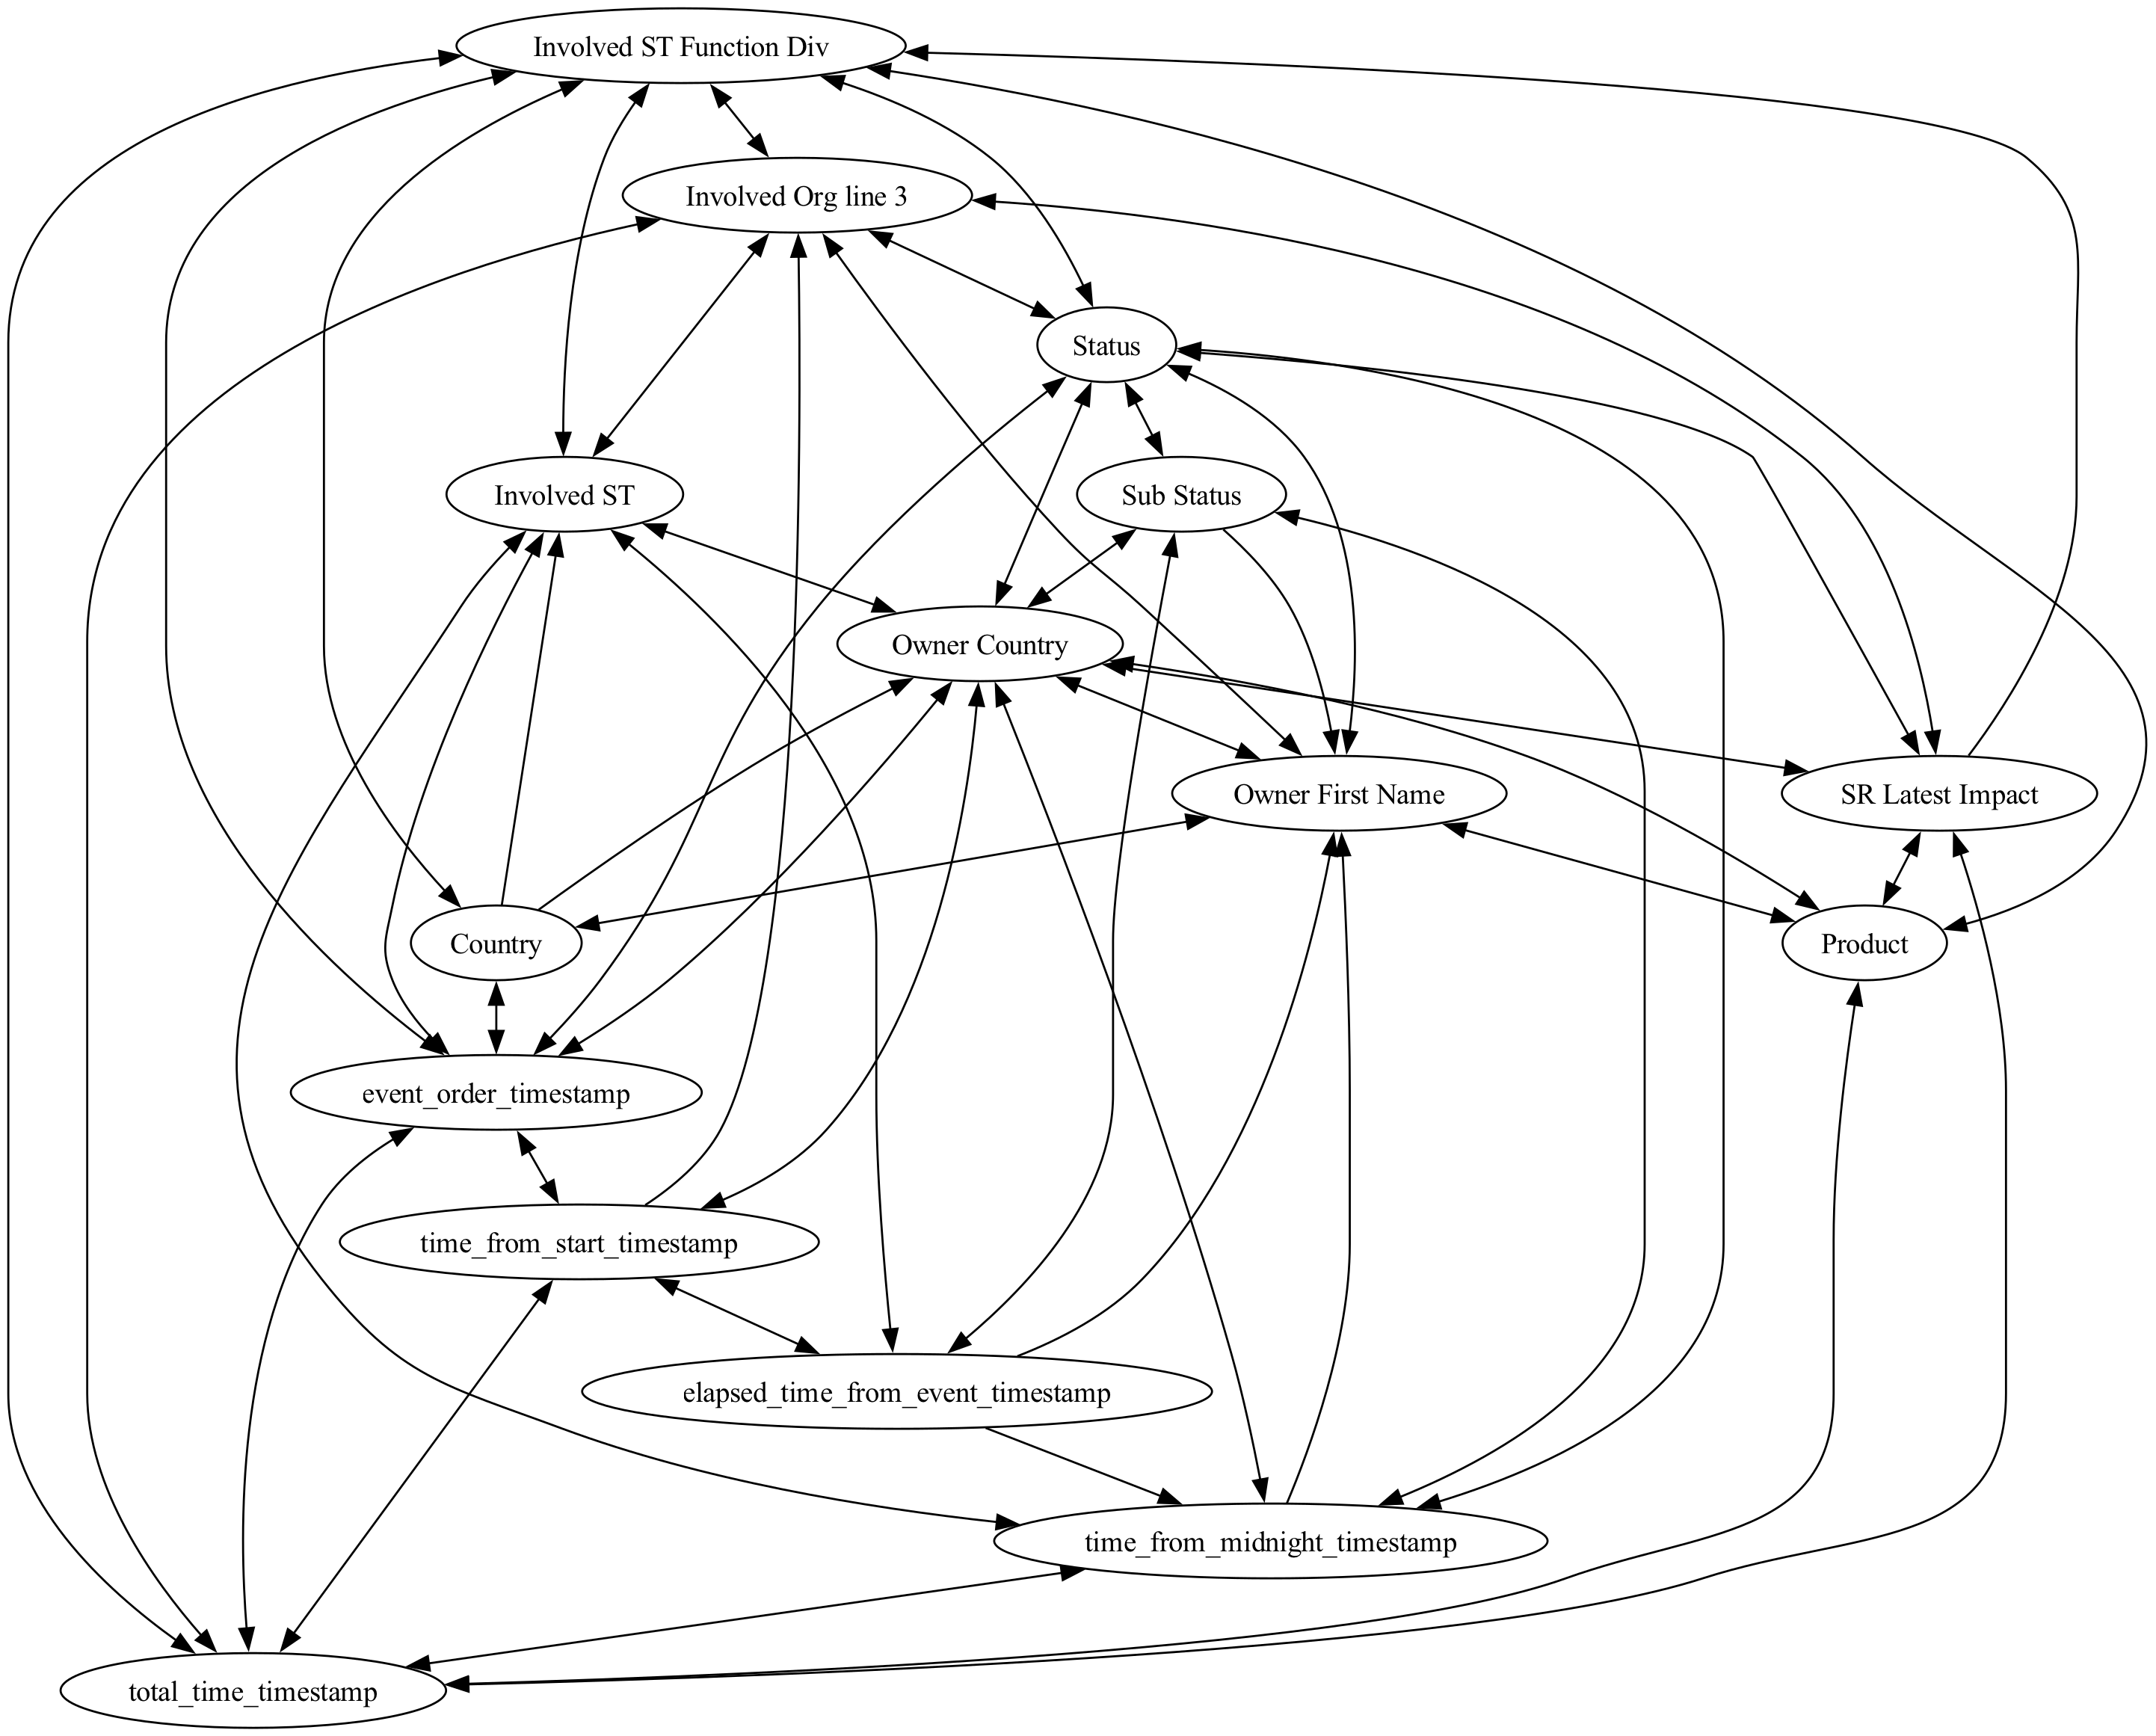

In [44]:
graph = causality.causal_inference_fci(dataset, "BPI2013")

In [45]:
target_index = dataset.columns.get_loc("elapsed_time_from_event_timestamp")

parents_index = causality.get_parents(
    graph, target_index
)

parents = dataset.columns[parents_index].tolist()
parents

['Involved ST', 'Sub Status', 'time_from_start_timestamp']

run only 1 order parents experiment

Split 0: 10923 train rows, 10922 test rows
{'mse': 4310.346738460422, 'rmse': 65.65323098264412, 'split': 0}


/Users/adrf/Desktop/work/process.mining/code/causal.predictive.monitoring/experiments/causality.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


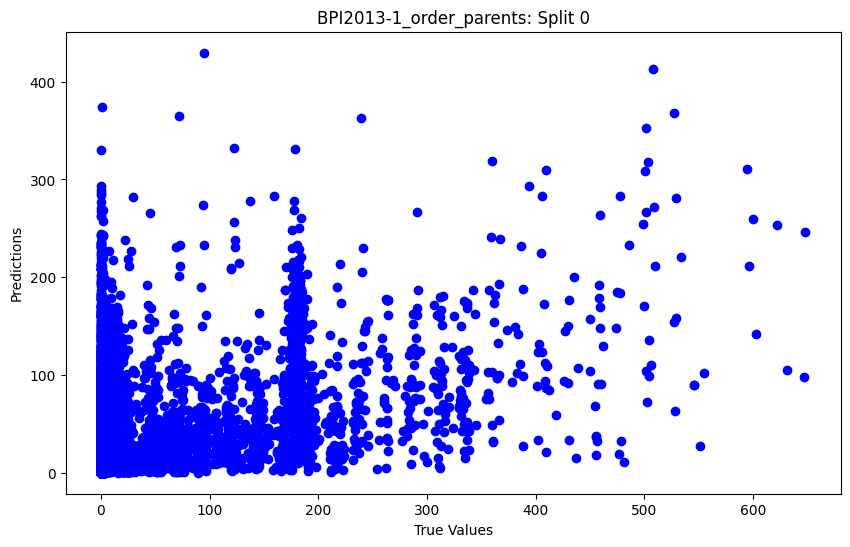

Split 1: 21845 train rows, 10922 test rows
{'mse': 2275.5443296248714, 'rmse': 47.70266585448733, 'split': 1}


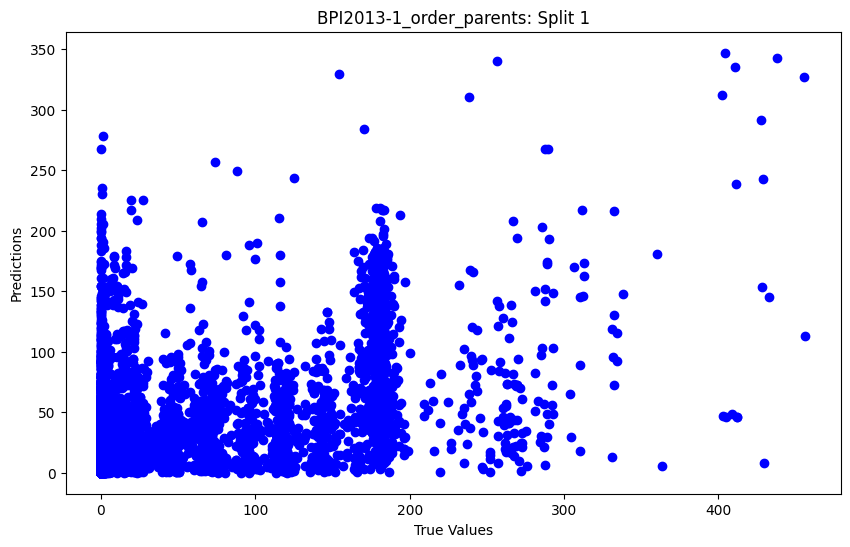

Split 2: 32767 train rows, 10922 test rows
{'mse': 945.7383315457688, 'rmse': 30.752858916623815, 'split': 2}


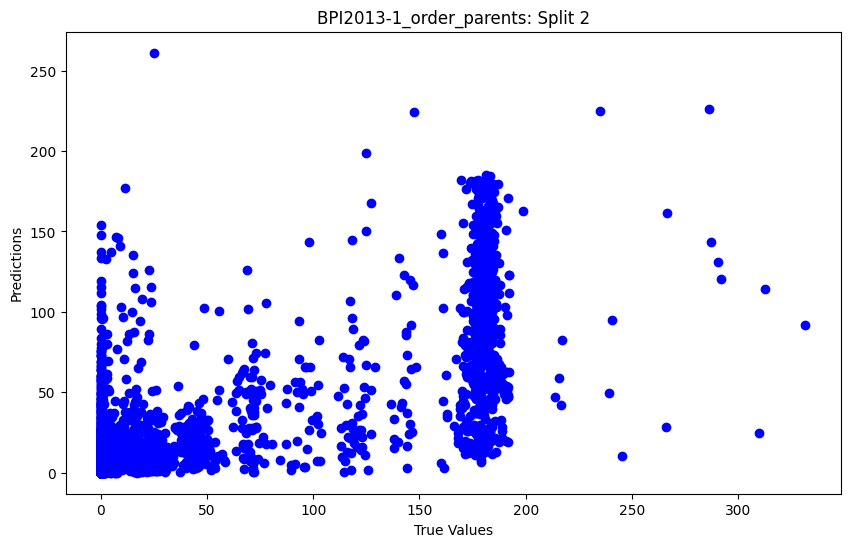

Split 3: 43689 train rows, 10922 test rows
{'mse': 420.08034775462085, 'rmse': 20.495861722665403, 'split': 3}


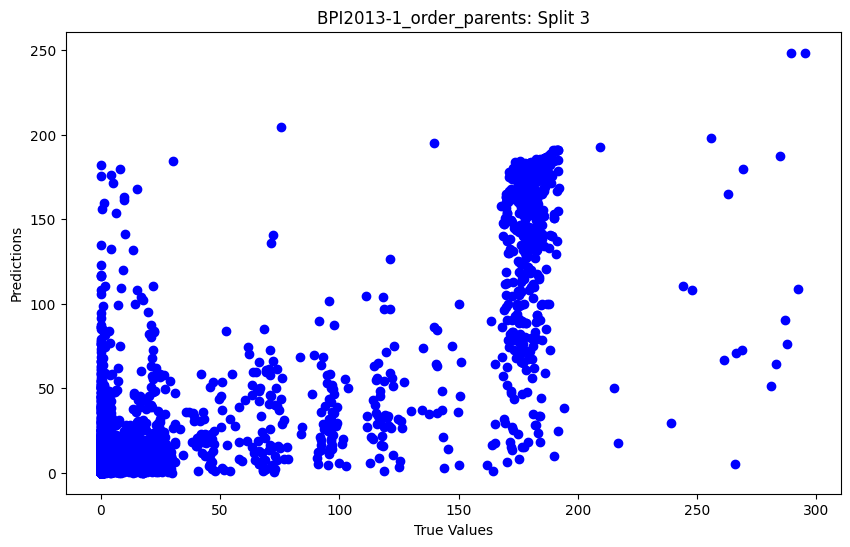

Split 4: 54611 train rows, 10922 test rows
{'mse': 390.54229638071223, 'rmse': 19.762143010835445, 'split': 4}


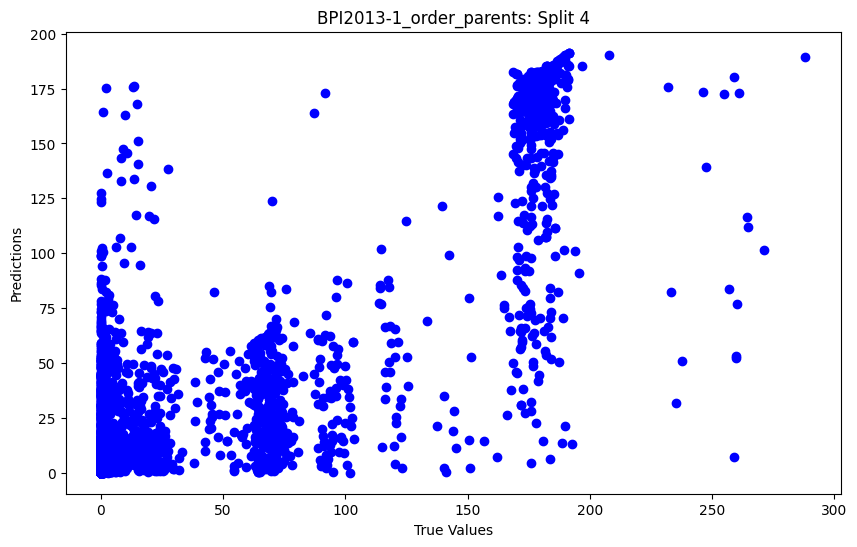

{'mse': 1668.4504087532791, 'rmse': 36.87335209745122}


In [46]:
columns = parents + ["elapsed_time_from_event_timestamp"]

results_1_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2013",
    experiment="1_order_parents",
    columns=columns,
)

run without parents experiments

Split 0: 10923 train rows, 10922 test rows
{'mse': 5997.964057793531, 'rmse': 77.44652385868284, 'split': 0}


/Users/adrf/Desktop/work/process.mining/code/causal.predictive.monitoring/experiments/causality.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


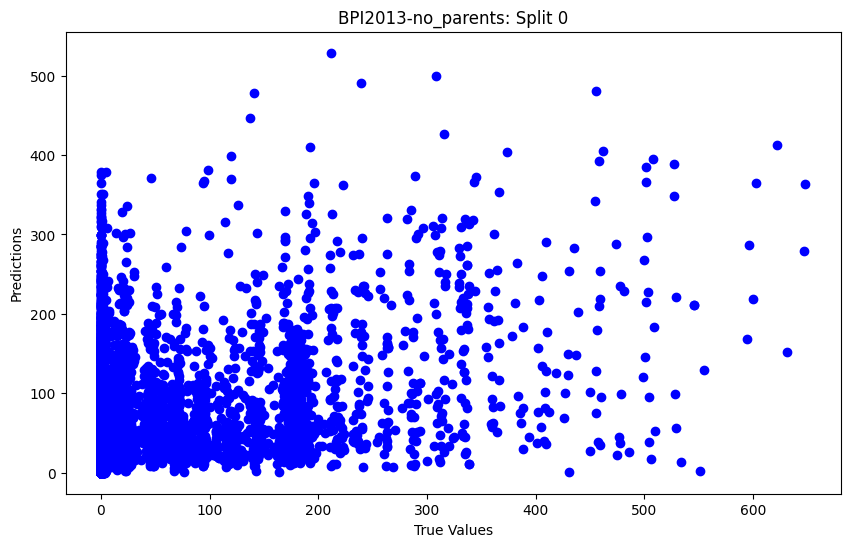

Split 1: 21845 train rows, 10922 test rows
{'mse': 2746.17776323973, 'rmse': 52.403986138839954, 'split': 1}


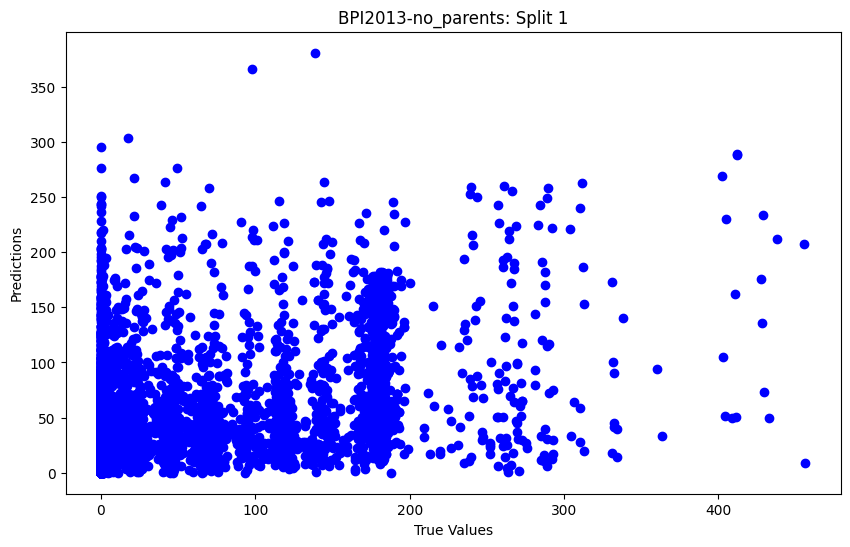

Split 2: 32767 train rows, 10922 test rows
{'mse': 1201.2040444278466, 'rmse': 34.65839067856219, 'split': 2}


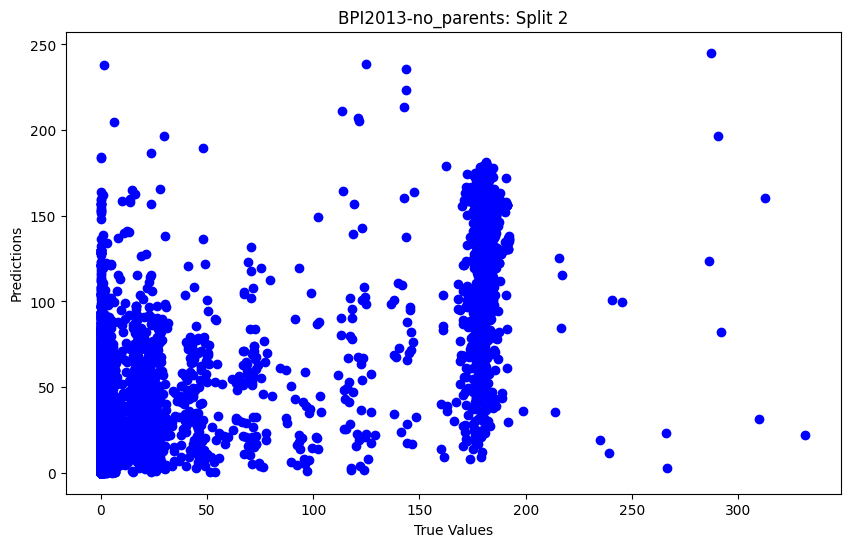

Split 3: 43689 train rows, 10922 test rows
{'mse': 454.3933005741044, 'rmse': 21.31650300997104, 'split': 3}


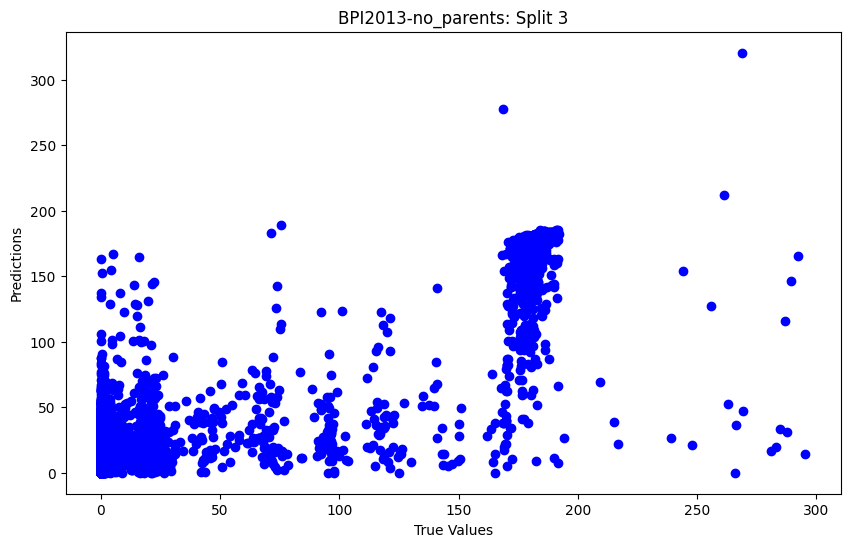

Split 4: 54611 train rows, 10922 test rows
{'mse': 400.23772582644546, 'rmse': 20.005942262898927, 'split': 4}


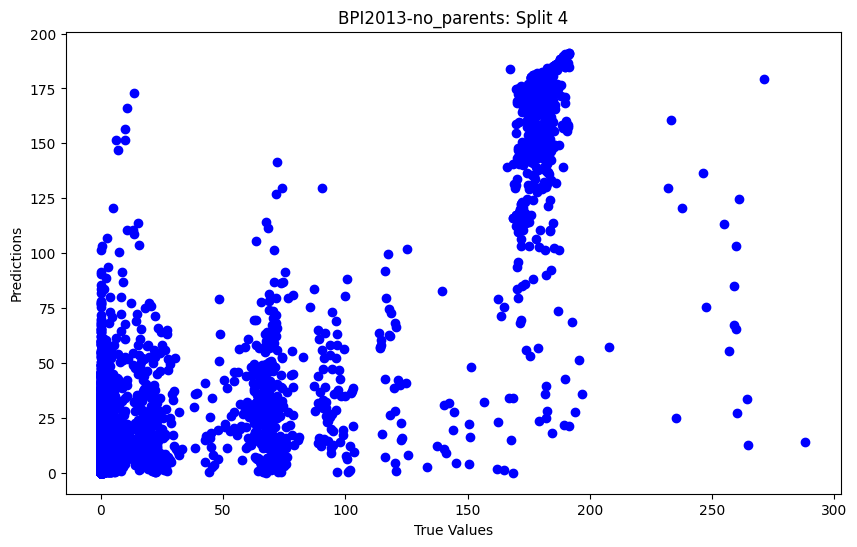

{'mse': 2159.9953783723313, 'rmse': 41.16626918979099}


In [47]:
columns = filter(lambda i: i not in parents, dataset.columns.tolist())

results_no_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2013",
    experiment="no_parents",
    columns=columns
)

run second order parents experiments

In [50]:
parents_2_order_index = causality.get_parents(
    graph, target_index, depth=2
)
parents_2_order = dataset.columns[parents_2_order_index].tolist()
parents_2_order

['Involved ST',
 'Involved ST Function Div',
 'Involved Org line 3',
 'Country',
 'Sub Status',
 'Status',
 'time_from_start_timestamp',
 'Owner Country',
 'event_order_timestamp']

/Users/adrf/Desktop/work/process.mining/code/causal.predictive.monitoring/experiments/causality.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[target], inplace=True)


Split 0: 10923 train rows, 10922 test rows
{'mse': 2928.622534298934, 'rmse': 54.11674911059361, 'split': 0}


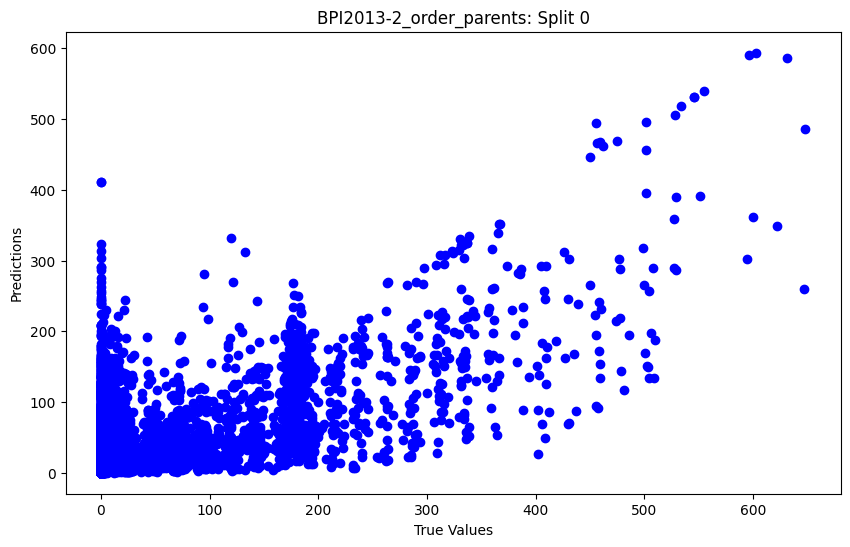

Split 1: 21845 train rows, 10922 test rows
{'mse': 1616.9203614984565, 'rmse': 40.21094827902541, 'split': 1}


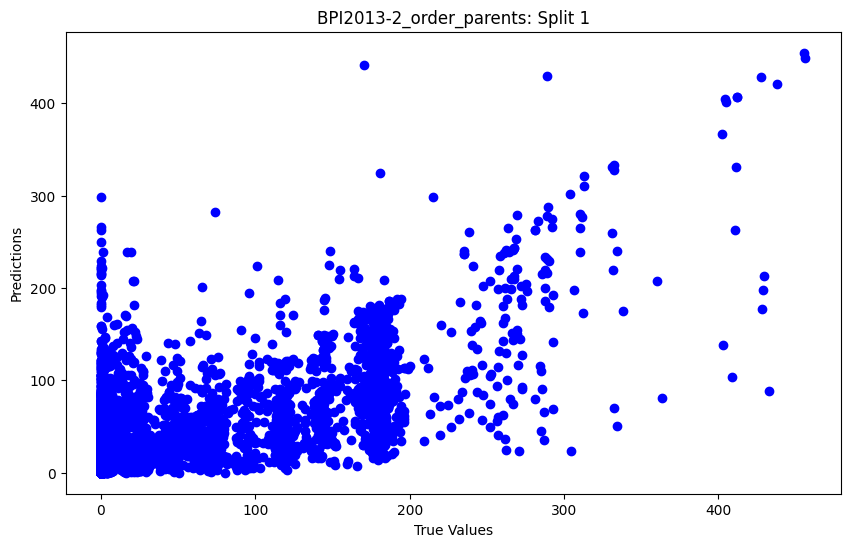

Split 2: 32767 train rows, 10922 test rows
{'mse': 610.0360167953623, 'rmse': 24.698907198403784, 'split': 2}


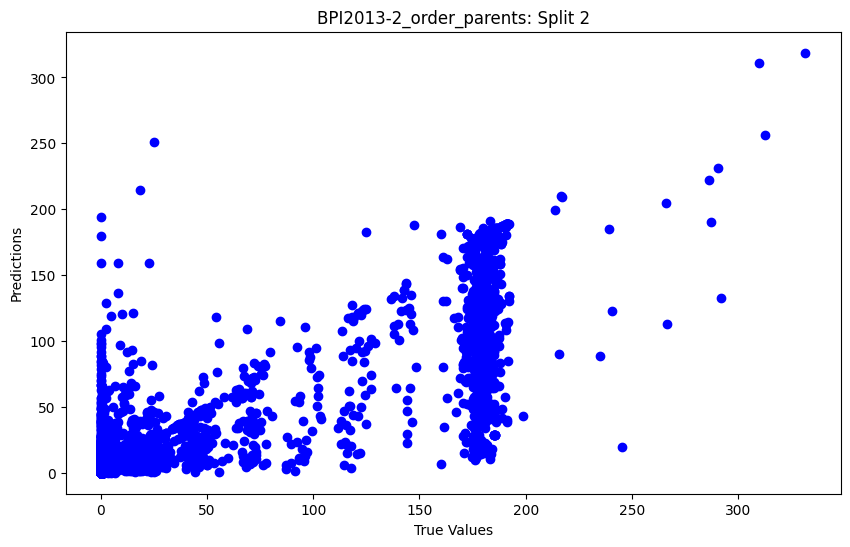

Split 3: 43689 train rows, 10922 test rows
{'mse': 286.2460190788836, 'rmse': 16.918806668287324, 'split': 3}


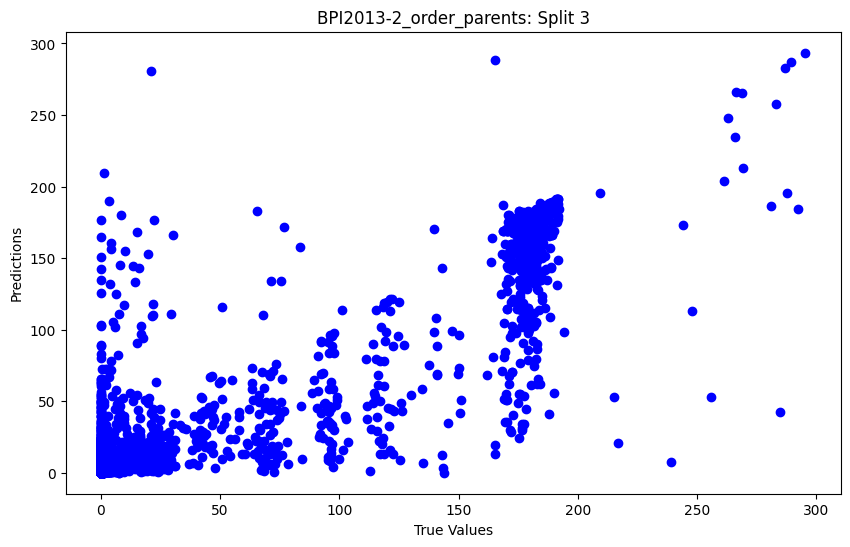

Split 4: 54611 train rows, 10922 test rows
{'mse': 232.8114687205322, 'rmse': 15.258160725347343, 'split': 4}


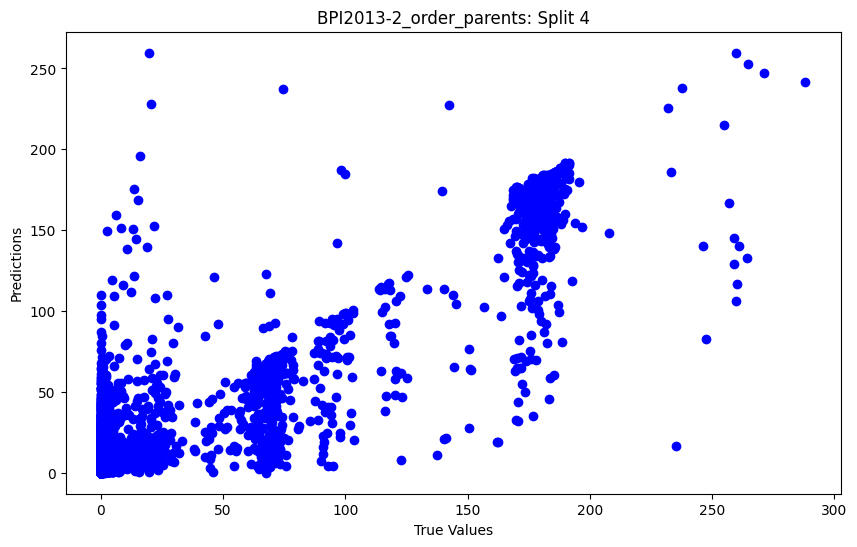

{'mse': 1134.9272800784338, 'rmse': 30.240714396331498}


In [51]:
columns = parents_2_order + ["elapsed_time_from_event_timestamp"]

results_2_order_parents = causality.run_experiment(
    dataset,
    target="elapsed_time_from_event_timestamp",
    name="BPI2013",
    experiment="2_order_parents",
    columns=columns
)